# Part A1: Define the Problem Setup
We'll start by:

Defining days, time slots, and rooms

Listing the factions

Generating the domains: All valid (day, time, room) slots

In [1]:
import itertools

# Summit setup
days = ['Day1', 'Day2', 'Day3']
rooms = ['Room1', 'Room2', 'Room3']
factions = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']

# 9 total (day, room) session slots
slots = [(day, room) for day in days for room in rooms]

# Generate all unique faction pairs (unordered, no repeats)
faction_pairs = list(itertools.combinations(factions, 2))

# We'll only need 9 of them for 9 sessions
session_vars = faction_pairs[:9]  # Note: we'll later refine this to ensure balance

# Domains: every faction pair can be assigned to any session slot
domains = {var: slots.copy() for var in session_vars}

# Print summary
print("Total slots:", len(slots))
print("Session Variables (Faction Pairs):", session_vars)


Total slots: 9
Session Variables (Faction Pairs): [('F1', 'F2'), ('F1', 'F3'), ('F1', 'F4'), ('F1', 'F5'), ('F1', 'F6'), ('F2', 'F3'), ('F2', 'F4'), ('F2', 'F5'), ('F2', 'F6')]


# Part A2: Generate Valid Faction Pairs (Each Faction Appears Exactly 3 Times)
We need 9 unique pairs, where:

Each faction appears in exactly 3 of them

No repeated matchups

This is a well-known balanced graph matching problem. Here's a small brute-force approach that tries combinations until one fits the 3-per-faction rule.

In [2]:
from itertools import combinations
import random

factions = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6']
all_pairs = list(combinations(factions, 2))

# Try random selections until one satisfies the 3-per-faction constraint
def generate_valid_pairs():
    attempts = 0
    while attempts < 10000:
        sample = random.sample(all_pairs, 9)
        freq = {f: 0 for f in factions}
        for f1, f2 in sample:
            freq[f1] += 1
            freq[f2] += 1
        if all(v == 3 for v in freq.values()):
            return sample
        attempts += 1
    return None

session_vars = generate_valid_pairs()
if session_vars is None:
    print("Failed to generate valid faction pairs.")
else:
    print("✅ Valid faction pairs generated:")
    for pair in session_vars:
        print(pair)


✅ Valid faction pairs generated:
('F1', 'F4')
('F1', 'F6')
('F3', 'F5')
('F2', 'F5')
('F1', 'F5')
('F2', 'F4')
('F3', 'F6')
('F2', 'F3')
('F4', 'F6')


# Part A3: Define CSP Constraint Checker
This function enforces:

❌ No faction meets another more than once (already handled via unique pairs)

❌ A faction can't be in two sessions on the same day (rest gap)

❌ No faction reuses the same room in consecutive days

❌ Rival factions (assume you define them) only meet in neutral rooms

In [3]:
def violates_constraints(assignments, var, value):
    assigned_day, assigned_room = value
    f1, f2 = var

    for other_var, other_value in assignments.items():
        if other_value is None:
            continue
        od, oroom = other_value
        of1, of2 = other_var

        # Constraint: same day conflict
        if (f1 in other_var or f2 in other_var) and assigned_day == od:
            return True

        # Constraint: consecutive room reuse
        if f1 in other_var or f2 in other_var:
            d_index = {'Day1': 0, 'Day2': 1, 'Day3': 2}
            if abs(d_index[assigned_day] - d_index[od]) == 1 and assigned_room == oroom:
                return True

        # Optional: neutral rooms (implement later when rivals are defined)
        # if (f1, f2) in rivals and assigned_room not in neutral_rooms:
        #     return True

    return False


# Part A4: CSP Solver with MRV and Forward Checking

In [4]:
import copy

# Minimum Remaining Values (MRV) heuristic
def select_unassigned_variable(assignment, domains):
    unassigned = [v for v in domains if v not in assignment]
    return min(unassigned, key=lambda var: len(domains[var]))

# Order domain values (no LCV needed here, just natural order)
def order_domain_values(var, domains):
    return domains[var]

# Forward checking: remove invalid domain values from neighbors
def forward_check(var, value, domains, assignment):
    temp_domains = copy.deepcopy(domains)
    for neighbor in temp_domains:
        if neighbor not in assignment:
            new_domain = []
            for val in temp_domains[neighbor]:
                test_assignment = assignment.copy()
                test_assignment[var] = value
                if not violates_constraints(test_assignment, neighbor, val):
                    new_domain.append(val)
            temp_domains[neighbor] = new_domain
            if not new_domain:
                return None  # Dead end
    return temp_domains

# Backtracking search with MRV + forward checking
def backtrack(assignment, domains):
    if len(assignment) == len(domains):
        return assignment

    var = select_unassigned_variable(assignment, domains)
    for value in order_domain_values(var, domains):
        if not violates_constraints(assignment, var, value):
            assignment[var] = value
            new_domains = forward_check(var, value, domains, assignment)
            if new_domains is not None:
                result = backtrack(assignment, new_domains)
                if result:
                    return result
            del assignment[var]
    return None


# Part A5: Run the Solver and Display Final Schedule

In [5]:
# Initialize domains (all slots available initially)
slots = [(day, room) for day in days for room in rooms]
domains = {var: slots.copy() for var in session_vars}

# Start solving
assignment = {}
solution = backtrack(assignment, domains)

# Display result
if solution:
    print("\n✅ Final 3D Schedule:")
    for session, slot in sorted(solution.items(), key=lambda x: x[1]):
        print(f"{slot[0]} | {slot[1]} → {session[0]} vs {session[1]}")
else:
    print("❌ No valid schedule found.")



✅ Final 3D Schedule:
Day1 | Room1 → F1 vs F4
Day1 | Room1 → F2 vs F5
Day1 | Room1 → F3 vs F6
Day2 | Room2 → F1 vs F6
Day2 | Room2 → F2 vs F4
Day2 | Room2 → F3 vs F5
Day3 | Room1 → F1 vs F5
Day3 | Room1 → F4 vs F6
Day3 | Room1 → F2 vs F3


# Part A6: Implement Arc Consistency (AC-3)
Arc Consistency means:

For every variable A, and every neighbor B, for each value in A’s domain, there exists some consistent value in B’s domain.

In [6]:
from collections import deque

def ac3(domains, constraints_func):
    queue = deque([(xi, xj) for xi in domains for xj in domains if xi != xj])

    while queue:
        xi, xj = queue.popleft()
        if revise(domains, xi, xj, constraints_func):
            if not domains[xi]:
                return False  # Domain wiped out
            for xk in domains:
                if xk != xi and xk != xj:
                    queue.append((xk, xi))
    return True

def revise(domains, xi, xj, constraints_func):
    revised = False
    new_domain = []
    for x in domains[xi]:
        # Keep x only if there is some y in xj's domain that satisfies constraints
        if any(not constraints_func({xi: x}, xj, y) for y in domains[xj]):
            new_domain.append(x)
        else:
            revised = True
    domains[xi] = new_domain
    return revised


# Part A7: Integrate AC-3 Before Backtracking

In [7]:
# Reinitialize domains
domains = {var: slots.copy() for var in session_vars}

# Apply AC-3 before starting backtracking
success = ac3(domains, violates_constraints)

if not success:
    print("❌ AC-3 failed: inconsistency detected before search.")
else:
    assignment = {}
    solution = backtrack(assignment, domains)

    if solution:
        print("\n✅ Final 3D Schedule with AC-3:")
        for session, slot in sorted(solution.items(), key=lambda x: x[1]):
            print(f"{slot[0]} | {slot[1]} → {session[0]} vs {session[1]}")
    else:
        print("❌ No valid schedule found (after AC-3).")



✅ Final 3D Schedule with AC-3:
Day1 | Room1 → F1 vs F4
Day1 | Room1 → F2 vs F5
Day1 | Room1 → F3 vs F6
Day2 | Room2 → F1 vs F6
Day2 | Room2 → F2 vs F4
Day2 | Room2 → F3 vs F5
Day3 | Room1 → F1 vs F5
Day3 | Room1 → F4 vs F6
Day3 | Room1 → F2 vs F3


# Step A8: Destroy a Room Randomly
This code randomly destroys a session's room and triggers repair

In [8]:
import random

def destroy_random_room(solution, domains):
    # Choose a session to destroy its room
    broken_var = random.choice(list(solution.keys()))
    broken_slot = solution[broken_var]

    print(f"\n⚠️ Room Destruction: {broken_slot[1]} on {broken_slot[0]} for session {broken_var}")

    # Remove the broken assignment
    del solution[broken_var]

    # Mark the (day, room) as unavailable
    unavailable_slot = broken_slot

    # Remove that slot from all domains
    for var in domains:
        domains[var] = [s for s in domains[var] if s != unavailable_slot]

    return broken_var, unavailable_slot


Step A9: Repair Only the Affected Assignment
We’ll reuse the backtrack method, but restrict it to just the broken session

In [9]:
def repair_assignment(broken_var, solution, domains):
    # Try to assign a new slot to the broken session
    for value in domains[broken_var]:
        if not violates_constraints(solution, broken_var, value):
            solution[broken_var] = value
            return True
    return False


# Full Simulation

In [10]:
# Initial solve with AC-3
domains = {var: slots.copy() for var in session_vars}
ac3(domains, violates_constraints)
assignment = {}
solution = backtrack(assignment, domains)

if solution:
    print("\n✅ Original Schedule:")
    for session, slot in sorted(solution.items(), key=lambda x: x[1]):
        print(f"{slot[0]} | {slot[1]} → {session[0]} vs {session[1]}")

    # Simulate dynamic room destruction
    broken_var, removed_slot = destroy_random_room(solution, domains)

    success = repair_assignment(broken_var, solution, domains)

    if success:
        print("\n🔁 Repaired Schedule:")
        for session, slot in sorted(solution.items(), key=lambda x: x[1]):
            print(f"{slot[0]} | {slot[1]} → {session[0]} vs {session[1]}")
    else:
        print(f"❌ Could not repair the schedule after destroying {removed_slot}")
else:
    print("❌ No valid initial schedule found.")



✅ Original Schedule:
Day1 | Room1 → F1 vs F4
Day1 | Room1 → F2 vs F5
Day1 | Room1 → F3 vs F6
Day2 | Room2 → F1 vs F6
Day2 | Room2 → F2 vs F4
Day2 | Room2 → F3 vs F5
Day3 | Room1 → F1 vs F5
Day3 | Room1 → F4 vs F6
Day3 | Room1 → F2 vs F3

⚠️ Room Destruction: Room2 on Day2 for session ('F3', 'F5')

🔁 Repaired Schedule:
Day1 | Room1 → F1 vs F4
Day1 | Room1 → F2 vs F5
Day1 | Room1 → F3 vs F6
Day2 | Room2 → F1 vs F6
Day2 | Room2 → F2 vs F4
Day2 | Room3 → F3 vs F5
Day3 | Room1 → F1 vs F5
Day3 | Room1 → F4 vs F6
Day3 | Room1 → F2 vs F3


# Task B1: Define Qualities, Actions, and Evaluation Function

In [11]:
# Qualities of rooms (bias): neutral or owned (simulate numeric bias)
room_quality = {'Room1': 3, 'Room2': 2, 'Room3': 1}

# Time slots implied from session order (early = better)
slot_quality = {'Early': 3, 'Mid': 2, 'Late': 1}

# Actions in negotiation
actions = ['Offer', 'Threaten', 'Bluff', 'Concede', 'Delay']


# Task B2: Evaluation Function

In [12]:
def evaluate_state(state, player, fatigue, trust_level):
    """
    Evaluate utility for a faction in negotiation.
    """
    room = state['room']
    slot = state['slot']  # Early/Mid/Late
    acting = state['player']

    score = 0
    score += room_quality.get(room, 0)
    score += slot_quality.get(slot, 0)
    score += trust_level
    score -= fatigue

    return score if acting == player else -score


# Task B3: Generate Next Game States

In [13]:
def generate_children(state, depth, player):
    """
    Create all possible next states by applying actions.
    """
    children = []
    for action in actions:
        new_room = state['room']
        new_slot = state['slot']

        if action == 'Offer':
            new_room = 'Room1'
            new_slot = 'Early'
        elif action == 'Threaten':
            new_room = 'Room2'
        elif action == 'Bluff':
            new_room = 'Room3'
        elif action in ['Concede', 'Delay']:
            pass  # No change

        next_player = 'B' if state['player'] == 'A' else 'A'

        children.append({
            'room': new_room,
            'slot': new_slot,
            'player': next_player,
            'action': action
        })
    return children


# Task B4: Minimax and Alpha-Beta

In [14]:
nodes_expanded = 0

def minimax(state, depth, player, fatigue, trust_level, maximizing):
    global nodes_expanded
    nodes_expanded += 1

    if depth == 0:
        return evaluate_state(state, player, fatigue, trust_level), state

    best_value = float('-inf') if maximizing else float('inf')
    best_state = None

    for child in generate_children(state, depth, player):
        val, _ = minimax(child, depth-1, player, fatigue+1, trust_level, not maximizing)
        if maximizing and val > best_value:
            best_value, best_state = val, child
        elif not maximizing and val < best_value:
            best_value, best_state = val, child

    return best_value, best_state


In [15]:
nodes_alpha_beta = 0

def alphabeta(state, depth, alpha, beta, player, fatigue, trust_level, maximizing):
    global nodes_alpha_beta
    nodes_alpha_beta += 1

    if depth == 0:
        return evaluate_state(state, player, fatigue, trust_level), state

    best_state = None
    if maximizing:
        value = float('-inf')
        for child in generate_children(state, depth, player):
            val, _ = alphabeta(child, depth-1, alpha, beta, player, fatigue+1, trust_level, False)
            if val > value:
                value, best_state = val, child
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return value, best_state
    else:
        value = float('inf')
        for child in generate_children(state, depth, player):
            val, _ = alphabeta(child, depth-1, alpha, beta, player, fatigue+1, trust_level, True)
            if val < value:
                value, best_state = val, child
            beta = min(beta, value)
            if alpha >= beta:
                break
        return value, best_state


# Task B5: Negotiation Simulation (Minimax vs Alpha-Beta)

In [16]:
# Format: (Faction A, Faction B, initial state)
negotiations = [
    ('F1', 'F2', {'room': 'Room3', 'slot': 'Late'}),
    ('F3', 'F4', {'room': 'Room2', 'slot': 'Mid'}),
    ('F5', 'F6', {'room': 'Room3', 'slot': 'Late'})
]


# ⚙️ Run Simulations

In [17]:
results = []

for p1, p2, state in negotiations:
    state_minimax = state.copy()
    state_minimax['player'] = p1
    nodes_expanded = 0
    score_mm, final_mm = minimax(state_minimax, depth=3, player=p1, fatigue=0, trust_level=0, maximizing=True)
    mm_nodes = nodes_expanded

    state_ab = state.copy()
    state_ab['player'] = p1
    nodes_alpha_beta = 0
    score_ab, final_ab = alphabeta(state_ab, depth=3, alpha=float('-inf'), beta=float('inf'),
                                   player=p1, fatigue=0, trust_level=0, maximizing=True)
    ab_nodes = nodes_alpha_beta

    results.append({
        'pair': f"{p1} vs {p2}",
        'minimax_action': final_mm['action'],
        'alphabeta_action': final_ab['action'],
        'minimax_score': score_mm,
        'alphabeta_score': score_ab,
        'minimax_nodes': mm_nodes,
        'alphabeta_nodes': ab_nodes
    })


Print Results

In [18]:
print("\n🔍 Negotiation Outcomes Comparison:")
for i, r in enumerate(results, 1):
    print(f"{i}. {r['pair']}")
    print(f"   Minimax     → Action: {r['minimax_action']} | Score: {r['minimax_score']} | Nodes: {r['minimax_nodes']}")
    print(f"   Alpha-Beta  → Action: {r['alphabeta_action']} | Score: {r['alphabeta_score']} | Nodes: {r['alphabeta_nodes']}")



🔍 Negotiation Outcomes Comparison:
1. F1 vs F2
   Minimax     → Action: Offer | Score: -1 | Nodes: 156
   Alpha-Beta  → Action: Offer | Score: -1 | Nodes: 52
2. F3 vs F4
   Minimax     → Action: Offer | Score: -1 | Nodes: 156
   Alpha-Beta  → Action: Offer | Score: -1 | Nodes: 52
3. F5 vs F6
   Minimax     → Action: Offer | Score: -1 | Nodes: 156
   Alpha-Beta  → Action: Offer | Score: -1 | Nodes: 52


# Task B6: Plot — Node Expansions Comparison

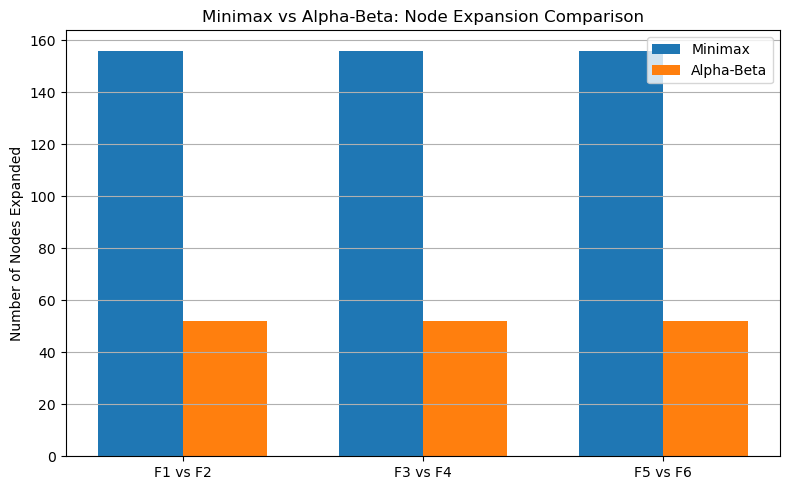

In [19]:
import matplotlib.pyplot as plt
import numpy as np

pairs = [r['pair'] for r in results]
mm_nodes = [r['minimax_nodes'] for r in results]
ab_nodes = [r['alphabeta_nodes'] for r in results]

x = np.arange(len(pairs))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, mm_nodes, width, label='Minimax')
plt.bar(x + width/2, ab_nodes, width, label='Alpha-Beta')
plt.xticks(x, pairs)
plt.ylabel("Number of Nodes Expanded")
plt.title("Minimax vs Alpha-Beta: Node Expansion Comparison")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Task B7: Plot — Final Utility Comparison

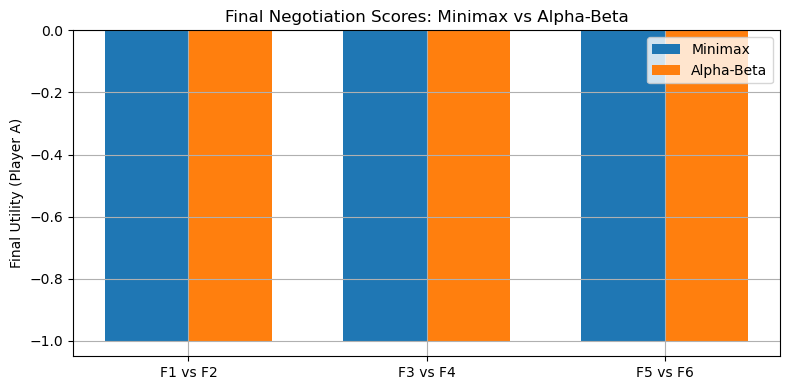

In [20]:
labels = [r['pair'] for r in results]
mm_scores = [r['minimax_score'] for r in results]
ab_scores = [r['alphabeta_score'] for r in results]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, mm_scores, width, label='Minimax')
plt.bar(x + width/2, ab_scores, width, label='Alpha-Beta')
plt.xticks(x, labels)
plt.ylabel("Final Utility (Player A)")
plt.title("Final Negotiation Scores: Minimax vs Alpha-Beta")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
